# Evaluating Contrastive Embedding

In [18]:
import os
import time
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.nn import functional as F

from quadrotor_diffusion.utils.dataset.normalizer import NormalizerTuple
from quadrotor_diffusion.utils.file import get_checkpoint_file
from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.vae import VAE_Wrapper
from quadrotor_diffusion.models.contrastive import ContrastiveWrapper
from quadrotor_diffusion.utils.dataset.boundary_condition import PolynomialTrajectory

from quadrotor_diffusion.utils.plotting import course_base_plot, add_gates_to_course

In [19]:
course_type = "u"
data_dir = "../data"

data = dict()

course_dir = os.path.join(data_dir, "courses", course_type)
for sample in os.listdir(course_dir):
    sample_dir = os.path.join(course_dir, sample)
    if not os.path.isdir(sample_dir):
        continue

    course_filename = os.path.join(sample_dir, "course.npy")
    if not os.path.exists(course_filename):
        continue
    data[course_filename] = list()
    # Find valid trajectories
    valid_dir = os.path.join(sample_dir, "valid")
    if os.path.exists(valid_dir):
        for valid_file in os.listdir(valid_dir):
            if valid_file.endswith(".pkl"):
                traj_filename = os.path.join(valid_dir, valid_file)

                # 1 for valid trajectory
                data[course_filename].append(traj_filename)

In [20]:
model: ContrastiveWrapper = None
normalizer: NormalizerTuple = None

chkpt = get_checkpoint_file("../logs/training", 73)
model, _, normalizer, _ = Trainer.load(chkpt, get_ema=False)
model = model.cuda()

traj_encoder: VAE_Wrapper = model.trajectory_encoder
print(chkpt)

../logs/training/73.ContrastiveWrapper.Feb.04_01:22_PM/checkpoints/epoch_19_loss_1.7859


In [21]:
course = list(data.keys())[48]
trajectory = data[course][0]

course_npy = np.load(course)
with open(trajectory, "rb") as file:
    trajectory: PolynomialTrajectory = pickle.load(file)

ref_pos = trajectory.as_ref_pos(pad_to=360)
trajectory = torch.tensor(ref_pos, dtype=torch.float32).unsqueeze(0).cuda()
mu = model.trajectory_encoder.encode(trajectory, padding=32)[0].squeeze(0)
mu = mu.transpose(-2, -1)
traj_embedding = model.trajectory_shallow_conv(mu)
traj_embedding = traj_embedding.transpose(-2, -1)
traj_embedding = model.trajectory_projection(traj_embedding).squeeze(0)

course = torch.tensor(course_npy, dtype=torch.float32).unsqueeze(0).cuda()
course_embedding = model.embed_course(course).squeeze(0)

traj_embedding = F.normalize(traj_embedding, p=2, dim=-1)
course_embedding = F.normalize(course_embedding, p=2, dim=-1)

cos_sim = torch.matmul(course_embedding, traj_embedding.T)
indices = torch.argmax(cos_sim, dim=1) * 4
indices = indices.cpu().numpy()

# To account for the padding
indices -= 32
print(indices)
print(traj_embedding.shape, course_embedding.shape, cos_sim.shape, indices.shape)

[  0  64 120 184 224 256]
torch.Size([106, 128]) torch.Size([6, 128]) torch.Size([6, 106]) (6,)


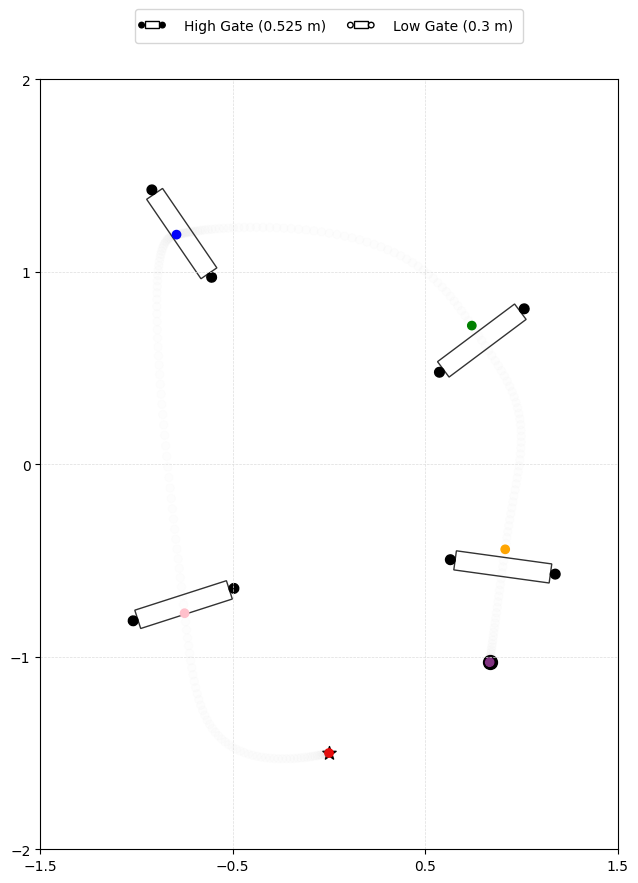

In [22]:
_, ax = course_base_plot()
add_gates_to_course(course_npy, ax)
colors = np.array(['#888888' for _ in range(len(ref_pos))])
alpha = np.array([0.01 for _ in range(len(ref_pos))])

for idx, c in zip(indices, ['red', 'pink', 'blue', 'green', 'orange', 'purple']):
    colors[idx] = c

alpha[indices] = 1.0

plt.scatter(ref_pos[:, 0], ref_pos[:, 1], c=colors, alpha=alpha)
plt.show()

In [23]:
print(model.get_alignment(course_embedding, mu))

ValueError: Invalid traj latent input

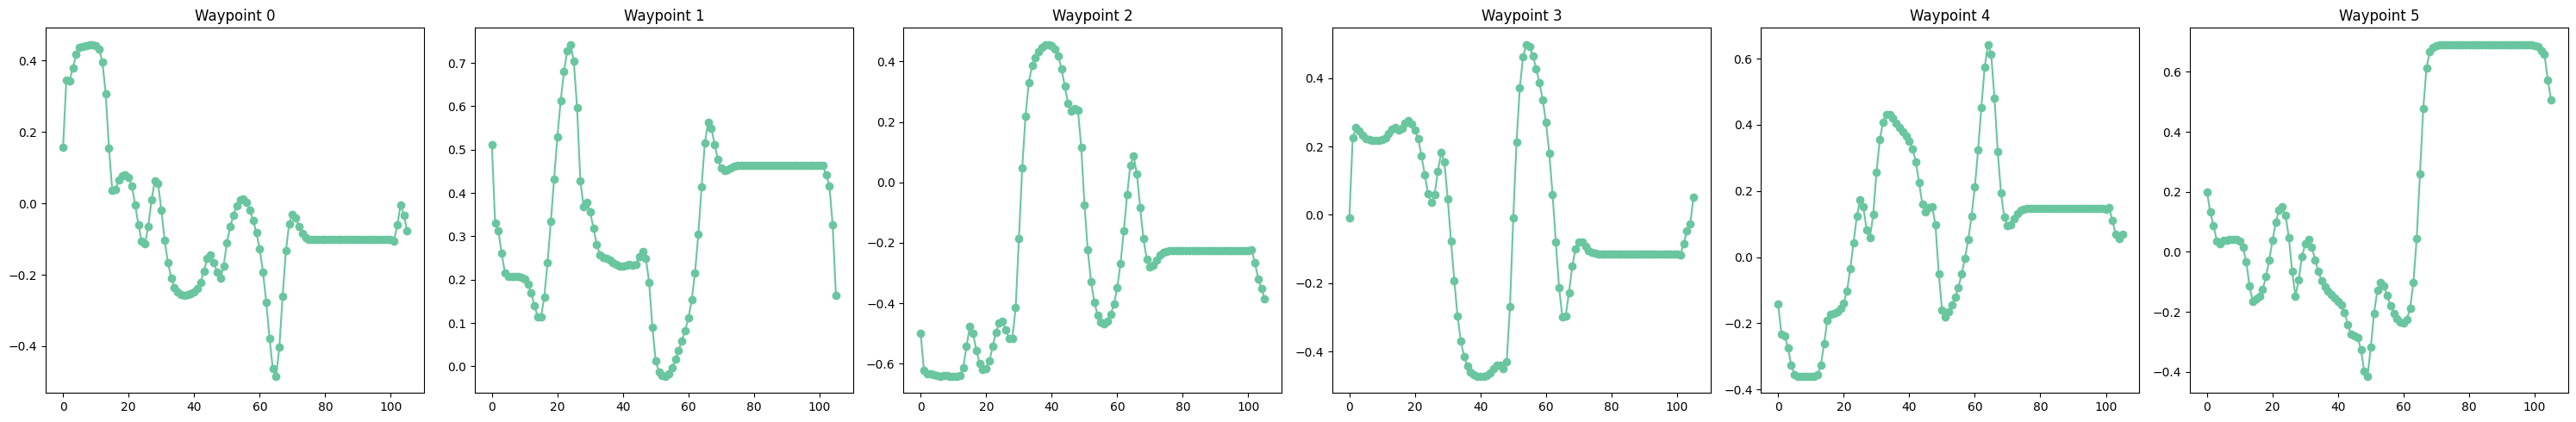

In [11]:
cos_sim = model.get_cosine_similarity(course_embedding, mu).squeeze(0)

fig, axes = plt.subplots(1, cos_sim.shape[0], figsize=(5 * cos_sim.shape[0], 5))
for i in range(cos_sim.shape[0]):
    axes[i].plot(cos_sim[i].cpu().detach().numpy())
    axes[i].scatter(range(len(cos_sim[i])), cos_sim[i].cpu().detach().numpy())
    axes[i].set_title(f'Waypoint {i}')

plt.tight_layout()
plt.show()


In [12]:
if input("should run? ") == "y":
    matched_alignments = []

    for course_filename in data:
        course = np.load(course_filename)
        course = torch.tensor(course_npy, dtype=torch.float32).unsqueeze(0).cuda()
        
        trajectories = []
        for trajectory in data[course_filename]:
            with open(trajectory, "rb") as file:
                trajectory: PolynomialTrajectory = pickle.load(file)

            ref_pos = trajectory.as_ref_pos(pad_to=360)
            trajectory = torch.tensor(ref_pos, dtype=torch.float32).unsqueeze(0).cuda()
            trajectories.append(trajectory)
        
        trajectories = torch.cat(trajectories)
        B = trajectories.shape[0]
        course = course.expand(B, -1, -1)
        
        mu = model.trajectory_encoder.encode(trajectories, padding=32)[0]
        course_embedding = model.embed_course(course)
        
        alignments = model.get_alignment(course_embedding, mu)
        for a in alignments:
            matched_alignments.append(a.item())

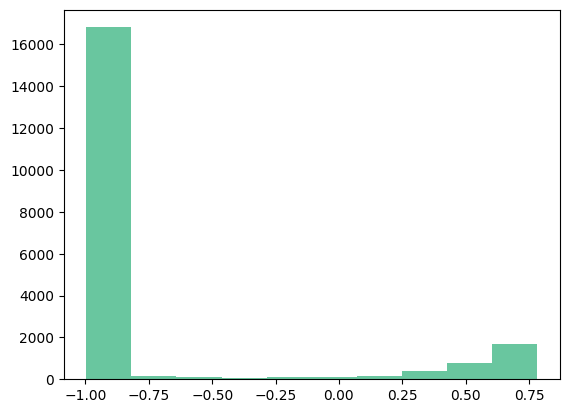

In [13]:
plt.hist(matched_alignments)
plt.show()